In [1]:
# %cd drive/My\ Drive/Colab\ Notebooks

In [2]:
# train_networks: Training CNNs to be used by the main program

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils
from processing import *

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.imshow(imgL)
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR)
    plt.title(titleR)
    plt.show(block=True)
    
# '''
def load_data(dataset):
    """
    Returns a list of dictionaries containing an image and the corresponding mask
    """
    
    data = []
    paths = [os.path.join(dataset, '01'), os.path.join(dataset, '02')]
    for path in paths:
        mask_path = path + '_ST'
        mask_path = os.path.join(mask_path, 'SEG')
        for f in os.listdir(mask_path):
            if not f.endswith(".tif"):
                continue
            image = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
            image = equalize_clahe(image).astype(np.float32)
            mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('mask', '')))
            
            # Generate the Cell Mask and Markers from the Mask
            cell_mask = (mask > 0).astype(np.uint8)
            markers = (get_markers(mask) > 0).astype(np.uint8)
            weight_map = get_weight_map(markers)
            
            # Pack the data for the DataLoader
            target = (cell_mask, markers, weight_map)
            data.append((np.array([image]), target))
            
    return DataLoader(data, batch_size=4, shuffle=True)
# '''
"""
def load_data(dataset):
    data = []
    path = os.path.join(dataset, "originals")
    clahe_path = path.replace("originals", "clahes")
    mask_path = path.replace("originals", "masks")
    markers_path = path.replace("originals", "markers")
    wm_path = path.replace("originals", "weight_maps")
    
    for f in os.listdir(path):
        if not f.endswith(".npy"):
            continue
#         image = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
#         clahe = cv2.imread(os.path.join(clahe_path, f), cv2.IMREAD_GRAYSCALE).astype(np.float32)
#         cell_mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
#         markers = cv2.imread(os.path.join(markers_path, f), cv2.IMREAD_UNCHANGED)
#         weight_map = cv2.imread(os.path.join(wm_path, f), cv2.IMREAD_UNCHANGED)
        
        image = np.load(os.path.join(path, f))
        clahe = np.load(os.path.join(clahe_path, f))
        cell_mask = np.load(os.path.join(mask_path, f))
        markers = np.load(os.path.join(markers_path, f))
        weight_map = np.load(os.path.join(wm_path, f))
        print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('mask', '')))
        
        # Generate the Cell Mask and Markers from the Mask
#         cell_mask = (mask > 0).astype(np.uint8)
#         markers = (preprocessing.get_markers(mask) > 0).astype(np.uint8)
#         weight_map = preprocessing.get_weight_map(markers)

#         weight_map = []
        # Pack the data for the DataLoader
        target = (cell_mask, markers, weight_map)
        data.append((np.array([clahe]), target))
            
    return DataLoader(data, batch_size=5, shuffle=True)
"""

'\ndef load_data(dataset):\n    data = []\n    path = os.path.join(dataset, "originals")\n    clahe_path = path.replace("originals", "clahes")\n    mask_path = path.replace("originals", "masks")\n    markers_path = path.replace("originals", "markers")\n    wm_path = path.replace("originals", "weight_maps")\n    \n    for f in os.listdir(path):\n        if not f.endswith(".npy"):\n            continue\n#         image = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)\n#         clahe = cv2.imread(os.path.join(clahe_path, f), cv2.IMREAD_GRAYSCALE).astype(np.float32)\n#         cell_mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)\n#         markers = cv2.imread(os.path.join(markers_path, f), cv2.IMREAD_UNCHANGED)\n#         weight_map = cv2.imread(os.path.join(wm_path, f), cv2.IMREAD_UNCHANGED)\n        \n        image = np.load(os.path.join(path, f))\n        clahe = np.load(os.path.join(clahe_path, f))\n        cell_mask = np.load(os.path.join(mask_path, f))\

In [3]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(768, 256, 3, padding=1)
        self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv13 = nn.Conv2d(384, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv15 = nn.Conv2d(192, 64, 3, padding=1)
        self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv17 = nn.Conv2d(96, 32, 3, padding=1)
        self.conv18 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv_out = nn.Conv2d(32, 2, 1)
        
    def forward(self, x):
        """
        Forward pass through the network
        """
        x = F.relu(self.conv1(x))
        contraction_32 = F.relu(self.conv2(x))
        
        x = F.max_pool2d(contraction_32, kernel_size=2)
        x = F.relu(self.conv3(x))
        contraction_64 = F.relu(self.conv4(x))
        
        x = F.max_pool2d(contraction_64, kernel_size=2)
        x = F.relu(self.conv5(x))
        contraction_128 = F.relu(self.conv6(x))
        
        x = F.max_pool2d(contraction_128, kernel_size=2)
        x = F.relu(self.conv7(x))
        contraction_256 = F.relu(self.conv8(x))
        
        x = F.max_pool2d(contraction_256, kernel_size=2)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_256, x), dim=1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_128, x), dim=1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_64, x), dim=1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_32, x), dim=1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        
        x = self.conv_out(x)
        output = F.softmax(x, dim=1)
        return output

# '''
def weighted_mean_sq_error(inputs, targets_m, targets_c, weights):

#     Weighted Cross-Entropy Loss takes in a weight map
#     and computes loss
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Another batch. Using device: " + str(device))
    
#     print(inputs.shape, targets_m.shape)
    
    inputs = inputs.to(device)
    targets = [targets_m.to(device), targets_c.to(device)]
    weights = weights.to(device)
    loss = torch.zeros(inputs.shape[0])

    # Calculate loss for each sample in the batch
    for sample in range(inputs.shape[0]):
#         print("Sample", sample+1)
        sample_loss, total_weight = 0.0, 0.0
        
        pred_markers = inputs[sample][0]
        pred_cmask = inputs[sample][1]
        
#         pimg(pred_markers.cpu().detach().numpy())
#         pimg(pred_cmasks.cpu().detach().numpy())
#         pimg(weights.cpu().detach().numpy())
        
        exp_markers = targets[0][sample]
        exp_cmask = targets[1][sample]
        
        numerator = weights[sample] * ( (pred_markers-exp_markers)**2 + (pred_cmask-exp_cmask)**2 )
        
        numerator = torch.sum(numerator)
        
        denominator = torch.sum(weights[sample])
#         print(np.unique(exp_markers), np.unique(exp_cmasks), numerator, denominator)
        sample_loss = 0.5 * (numerator/denominator)
        
        loss[sample] = sample_loss

    return torch.mean(loss)
# '''

'''
def weighted_mean_sq_error(inputs, targets, weights):

#     Weighted Cross-Entropy Loss takes in a weight map
#     and computes loss
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Another batch. Using device: " + str(device))
    
    inputs = inputs.to(device)
    targets = targets.to(device)
    weights = weights.to(device)
    loss = torch.zeros(inputs.shape[0])

    # Calculate loss for each sample in the batch
    for sample in range(inputs.shape[0]):
#         print("Sample", sample+1)
        sample_loss, total_weight = 0.0, 0.0
        
        pred = inputs[sample]
        
#         pimg(pred_markers.cpu().detach().numpy())
#         pimg(pred_cmasks.cpu().detach().numpy())
#         pimg(weights.cpu().detach().numpy())
        
        exp = targets[sample]
        
        numerator = weights[sample] * ( (pred-exp)**2 )
        
        numerator = torch.sum(numerator)
        
        denominator = torch.sum(weights[sample])
#         print(np.unique(exp_markers), np.unique(exp_cmasks), numerator, denominator)
        sample_loss = (numerator/denominator)
        
        loss[sample] = sample_loss

    return torch.mean(loss)
'''

def main():
    """
    Train 2 networks for predicting markers and the cell mask respectively
    Set trains on data from "Sequence 1 Masks" and "Sequence 2 Masks"
    and save the models
    """
    torch.cuda.set_device(0)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device: " + str(device))
    
    # Net M predicts the markers. Net C predicts the cell mask
#     net_m, net_c = Network().to(device), Network().to(device)
    net = Network().to(device)
    
    # criterion = F.nll_loss
#     criterion = weighted_cross_entropy_loss
    criterion = weighted_mean_sq_error
    
    # Optimising using Adam algorithm
#     optimiser_m = optim.Adam(net_m.parameters(), lr=0.001)
#     optimiser_c = optim.Adam(net_c.parameters(), lr=0.001)
    optimiser = optim.Adam(net.parameters(), lr=0.001)
    
    # Iterate over a number of epochs on the data
    for epoch in range(100):
        for i, batch in enumerate(trainLoader):
            x = batch[0].to(device)
            target = batch[1]
            cell_masks, markers, weight_map = \
                target[0].to(device), target[1].to(device), target[2].to(device) # Unpack target data

            # Clear gradients from last step
#             optimiser_m.zero_grad()
#             optimiser_c.zero_grad()
            optimiser.zero_grad()

            # Predict the markers from the image
#             output_m = net_m(x)
            output = net(x)
    
            # loss_m = criterion(output_m, markers.long())
#             loss_m = criterion(output_m, markers.float(), weight_map)
            loss = criterion(output, markers.float(), cell_masks.float(), weight_map)

#             loss_m.backward()
#             optimiser_m.step()

            loss.backward()
            optimiser.step()
            
#             # Predict the Cell Mask from the image
#             output_c = net_c(x)
#             loss_c = criterion(output_c, cell_masks.float(), weight_map)
        
#             # loss_c = criterion(output_c, cell_masks.long())
            
#             loss_c.backward()
#             optimiser_c.step()

            if i == 0 or (i + 1) % 10 == 0:
                print(f"Epoch: {epoch+1}, Batch: {i + 1}")
                print(f"Cell Mask Loss: {loss.item():.2f}, Markers Loss: {loss.item():.2f}")
                
                plt.imshow(x[0][0].cpu(), cmap='gray')
                plt.title("Input")
                plt.show()

                # Get the predicted Cell Mask and Markers for one of the images
#                 pred_c = torch.argmax(output_c[0], dim=0).cpu()
#                 pred_m = torch.argmax(output_m[0], dim=0).cpu()
                pred_m = torch.argmax(output[0], dim=0).cpu()
                pred_c = torch.argmax(output[1], dim=0).cpu()
                
                # Compare predicted to true images
                plot_two_images(pred_c, cell_masks[0].cpu(), "Predicted Cell Mask", "True Cell Mask")
                plot_two_images(pred_m, markers[0].cpu(), "Predicted Markers", "True Markers")

#     torch.save(net_m.state_dict(), "./CNN_m.pth")
#     torch.save(net_c.state_dict(), "./CNN_c.pth")
    torch.save(net.state_dict(), "./CNN_m.pth")
    
    print("Saved models.")

In [4]:
print("Loading Data...")
trainLoader = load_data('DIC-2')
print("Finished.")

Loading Data...
   Loaded DIC-2\01_ST\SEG\man_seg000.tif, DIC-2\01\man_seg000.tif
   Loaded DIC-2\01_ST\SEG\man_seg001.tif, DIC-2\01\man_seg001.tif
   Loaded DIC-2\01_ST\SEG\man_seg002.tif, DIC-2\01\man_seg002.tif
   Loaded DIC-2\01_ST\SEG\man_seg003.tif, DIC-2\01\man_seg003.tif
   Loaded DIC-2\01_ST\SEG\man_seg004.tif, DIC-2\01\man_seg004.tif
   Loaded DIC-2\01_ST\SEG\man_seg005.tif, DIC-2\01\man_seg005.tif
   Loaded DIC-2\01_ST\SEG\man_seg006.tif, DIC-2\01\man_seg006.tif
   Loaded DIC-2\01_ST\SEG\man_seg007.tif, DIC-2\01\man_seg007.tif
   Loaded DIC-2\01_ST\SEG\man_seg008.tif, DIC-2\01\man_seg008.tif
   Loaded DIC-2\01_ST\SEG\man_seg009.tif, DIC-2\01\man_seg009.tif
   Loaded DIC-2\01_ST\SEG\man_seg010.tif, DIC-2\01\man_seg010.tif
   Loaded DIC-2\01_ST\SEG\man_seg011.tif, DIC-2\01\man_seg011.tif
   Loaded DIC-2\01_ST\SEG\man_seg012.tif, DIC-2\01\man_seg012.tif
   Loaded DIC-2\01_ST\SEG\man_seg013.tif, DIC-2\01\man_seg013.tif
   Loaded DIC-2\01_ST\SEG\man_seg014.tif, DIC-2\01\man_seg01

   Loaded DIC-2\02_ST\SEG\man_seg040.tif, DIC-2\02\man_seg040.tif
   Loaded DIC-2\02_ST\SEG\man_seg041.tif, DIC-2\02\man_seg041.tif
   Loaded DIC-2\02_ST\SEG\man_seg042.tif, DIC-2\02\man_seg042.tif
   Loaded DIC-2\02_ST\SEG\man_seg043.tif, DIC-2\02\man_seg043.tif
   Loaded DIC-2\02_ST\SEG\man_seg044.tif, DIC-2\02\man_seg044.tif
   Loaded DIC-2\02_ST\SEG\man_seg045.tif, DIC-2\02\man_seg045.tif
   Loaded DIC-2\02_ST\SEG\man_seg046.tif, DIC-2\02\man_seg046.tif
   Loaded DIC-2\02_ST\SEG\man_seg047.tif, DIC-2\02\man_seg047.tif
   Loaded DIC-2\02_ST\SEG\man_seg048.tif, DIC-2\02\man_seg048.tif
   Loaded DIC-2\02_ST\SEG\man_seg049.tif, DIC-2\02\man_seg049.tif
   Loaded DIC-2\02_ST\SEG\man_seg050.tif, DIC-2\02\man_seg050.tif
   Loaded DIC-2\02_ST\SEG\man_seg051.tif, DIC-2\02\man_seg051.tif
   Loaded DIC-2\02_ST\SEG\man_seg052.tif, DIC-2\02\man_seg052.tif
   Loaded DIC-2\02_ST\SEG\man_seg053.tif, DIC-2\02\man_seg053.tif
   Loaded DIC-2\02_ST\SEG\man_seg054.tif, DIC-2\02\man_seg054.tif
   Loaded 

Using device: cuda:0


E:\Anaconda\envs\compvis\lib\site-packages\torch\nn\functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Another batch. Using device: cuda:0
Epoch: 1, Batch: 1
Cell Mask Loss: 0.22, Markers Loss: 0.22


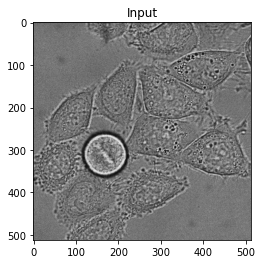

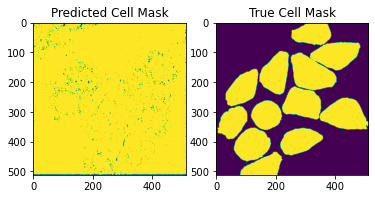

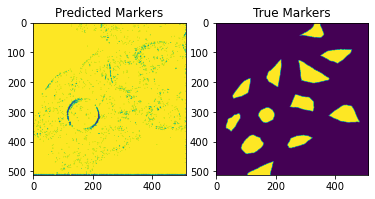

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 1, Batch: 10
Cell Mask Loss: 0.29, Markers Loss: 0.29


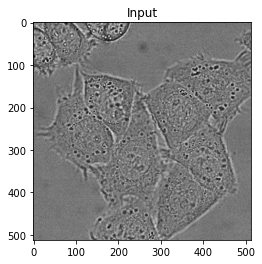

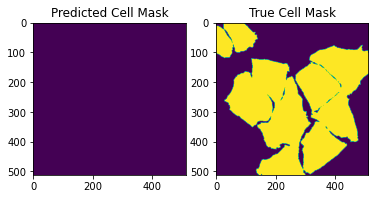

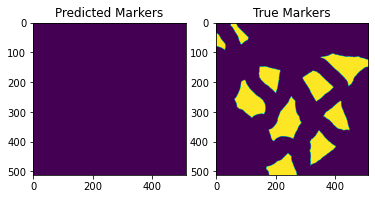

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 1, Batch: 20
Cell Mask Loss: 0.29, Markers Loss: 0.29


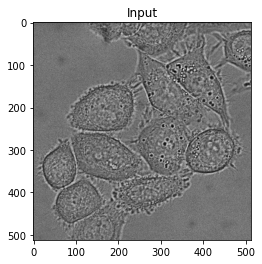

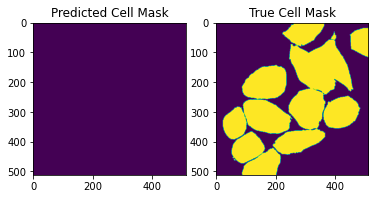

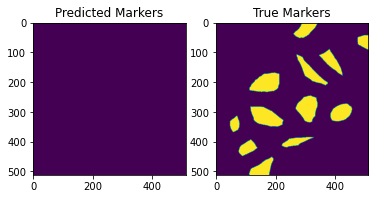

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 1, Batch: 30
Cell Mask Loss: 0.28, Markers Loss: 0.28


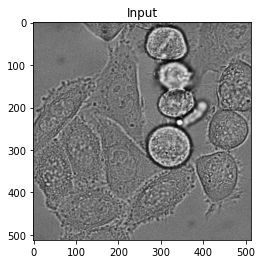

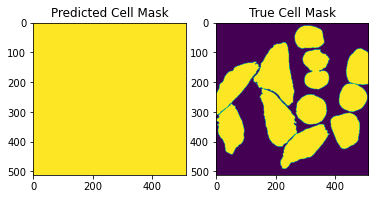

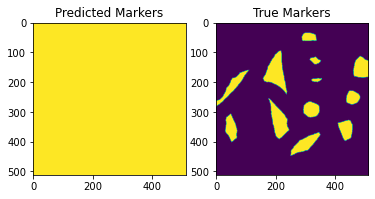

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 1, Batch: 40
Cell Mask Loss: 0.27, Markers Loss: 0.27


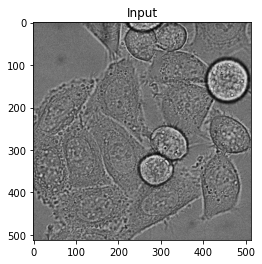

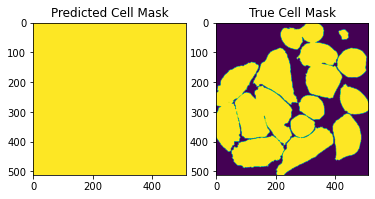

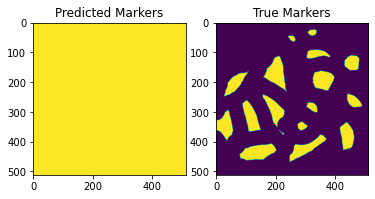

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 2, Batch: 1
Cell Mask Loss: 0.28, Markers Loss: 0.28


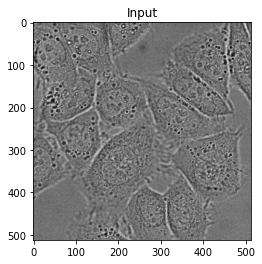

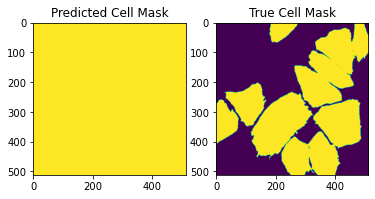

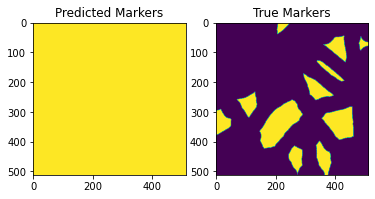

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 2, Batch: 10
Cell Mask Loss: 0.28, Markers Loss: 0.28


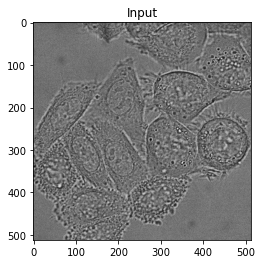

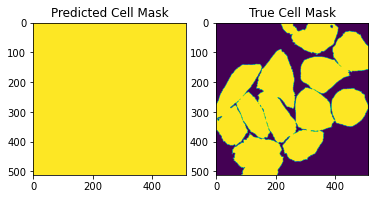

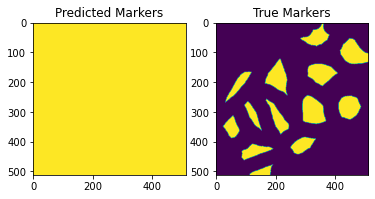

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 2, Batch: 20
Cell Mask Loss: 0.27, Markers Loss: 0.27


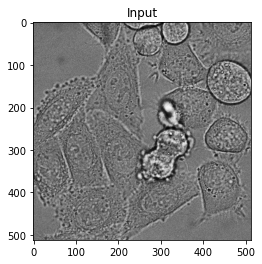

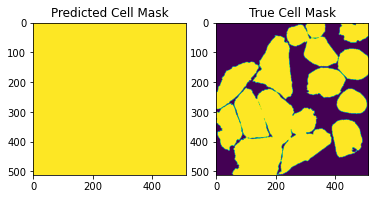

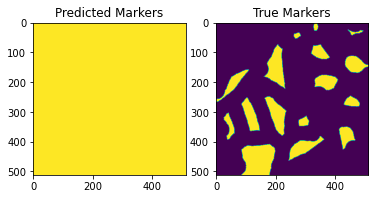

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 2, Batch: 30
Cell Mask Loss: 0.28, Markers Loss: 0.28


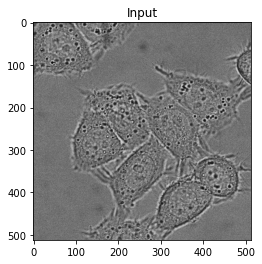

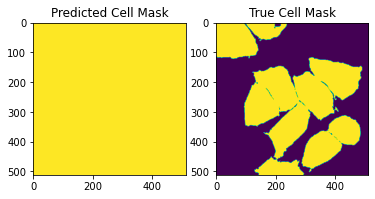

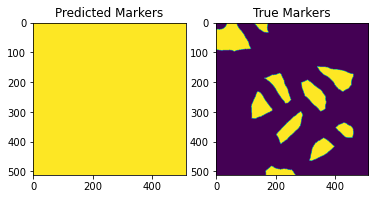

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 2, Batch: 40
Cell Mask Loss: 0.28, Markers Loss: 0.28


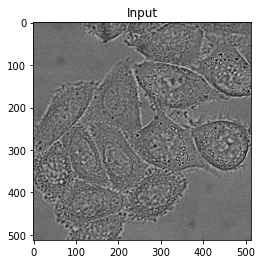

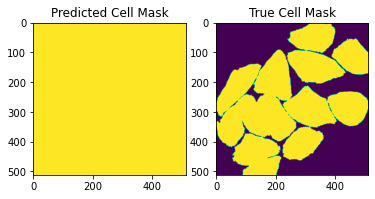

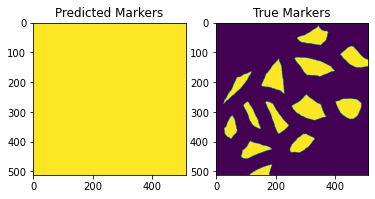

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 3, Batch: 1
Cell Mask Loss: 0.30, Markers Loss: 0.30


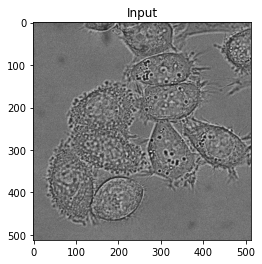

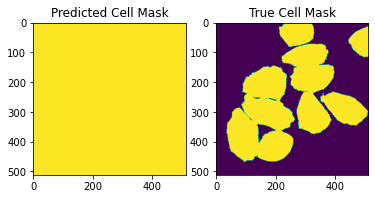

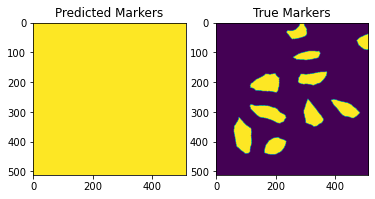

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 3, Batch: 10
Cell Mask Loss: 0.29, Markers Loss: 0.29


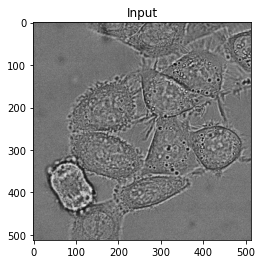

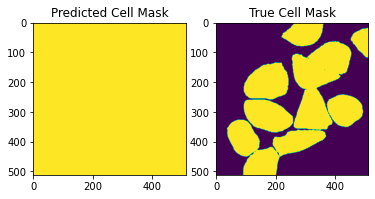

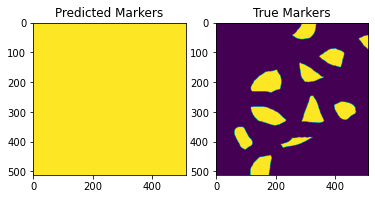

Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Another batch. Using device: cuda:0
Epoch: 3, Batch: 20
Cell Mask Loss: 0.28, Markers Loss: 0.28


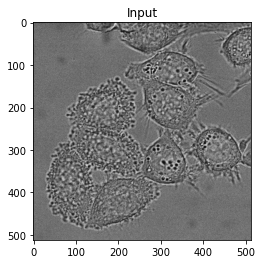

KeyboardInterrupt: 

In [5]:
if __name__ == '__main__':
    main()